In [213]:
# #these are the times available that you can select
# testable_times = [10, 15, 20, 30, 40, 60]

# def subset(time_choice):

#   ##create our tuple list of possible times for "realtime.mins" depending on selection
#   if time_choice == 10:
#     sections = np.linspace(0,60, 13)

#   elif time_choice == 20:
#     sections = np.linspace(0,60,7)

#   elif time_choice == 30 or time_choice == 15:
#     sections = np.linspace(0,60,5)

#   else:
#     sections = np.linspace(0,60,4)

#   pair_order_list = itertools.combinations(sections,2)

#   combo_list = (list(pair_order_list))

#   #remove times that don't make sense (ie if we select 10 mins, we want 2 tuples of 5 mins, whereas tuples of 20 minutes don't add to 10)
#   count = 0
#   if time_choice == 15:
#     while count < (len(combo_list) -1):
#       for item in combo_list:
#         if (item[1] - item[0] > time_choice) :
#           combo_list.remove(item)
#       count +=1
#     return combo_list

#   else:
#     while count < (len(combo_list) -1):
#       for item in combo_list:
#         if (item[1] - item[0] > time_choice/2) :
#           combo_list.remove(item)
#       count +=1
    
#   #then, we want to go through permutations of every two of those and do our sampling
#   tuple_list  = (list(itertools.permutations(combo_list, 2)))

#   if time_choice == 60:
#     tuple_list = [(0,60)]

#   #remove duplicates that are backwards
#   tuple_list =  list(set(map(tuple, map(sorted, tuple_list))))

#   #filter to get all of the possibilities in a dictionary
#   diction = {}
#   for i in range(0, len(tuple_list)):  
#     time_list = []
#     pt1 = vo9[(vo9["realtime.min"] >= tuple_list[i][0][0]) & (vo9["realtime.min"] <= tuple_list[i][0][1])]
#     pt2 = vo9[(vo9["realtime.min"] >= tuple_list[i][1][0]) & (vo9["realtime.min"] <= tuple_list[i][1][1])]
#     new_subset=pd.concat([pt1, pt2], axis = 0)

#     #add column for time
#     time_list.append([tuple_list[i][0][0], tuple_list[i][0][1], tuple_list[i][1][0], tuple_list[i][1][1]])
#     new_subset["times"] = str(time_list)
#     diction[i] = new_subset


#   return diction




#   ##now, how do we return the best of the subsets?


# subset(20)

{0:         vo.num     hh  clip  ...   actobj.class     X                       times
 0          vo1  10308  1199  ...  Touch_fomites     1  [[20.0, 30.0, 40.0, 50.0]]
 1          vo1  10308  1199  ...          NA_NA     1  [[20.0, 30.0, 40.0, 50.0]]
 2          vo1  10308  1199  ...          NA_NA     1  [[20.0, 30.0, 40.0, 50.0]]
 3          vo1  10308  1199  ...          NA_NA     1  [[20.0, 30.0, 40.0, 50.0]]
 4          vo1  10308  1199  ...  Touch_fomites     1  [[20.0, 30.0, 40.0, 50.0]]
 ...        ...    ...   ...  ...            ...   ...                         ...
 1291359    vo3  71103  2123  ...          NA_NA  1305  [[20.0, 30.0, 40.0, 50.0]]
 1291360    vo3  71103  2123  ...  Touch_Nothing  1305  [[20.0, 30.0, 40.0, 50.0]]
 1291361    vo3  71103  2123  ...          NA_NA  1305  [[20.0, 30.0, 40.0, 50.0]]
 1291362    vo3  71103  2123  ...          NA_NA  1305  [[20.0, 30.0, 40.0, 50.0]]
 1291363    vo3  71103  2123  ...          NA_NA  1305  [[20.0, 30.0, 40.0, 50.0]]
 

In [68]:
import os
import csv
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import itertools

from cycler import concat

from numpy.core.numeric import NaN
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid






cwd = os.getcwd()

Part 1: Pre-Processing

In [69]:
#Loading data
vo9 = pd.read_csv(r'/content/vo.9.csv')


In [70]:
#Make a copy
df2 = vo9.copy()

#Focusing specifically on right hand because of cultural norms
df2 = df2[df2["hand"] == "R"]

#Remove rows where Nothing happens
dfact = df2[(df2["obj"]!="Nothing") & (~df2["obj"].isna())]

#each row should be a single possible exposure
dfact["freq"] = 1 

#Example of how we will group by identifier, video clip, act and object to get total frequencies and durations per exposure
dfact.groupby(["hh", "vo.num", "clip", "act", "obj"])[["realtime.min", "dur", "freq"]].sum().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,hh,vo.num,clip,act,obj,realtime.min,dur,freq
0,2302,vo1,1635,Mouth,ChildHand,507,211.219596,16
1,2302,vo1,1635,Mouth,Plastic,115,214.979614,4
2,2302,vo1,1635,Touch,ChildHand,2088,250.459629,63
3,2302,vo1,1635,Touch,Cloth,1137,258.459604,30
4,2302,vo1,1635,Touch,Metal,21,17.849956,4
...,...,...,...,...,...,...,...,...
6876,71105,vo1,1626,Touch,Cloth,1345,586.898901,57
6877,71105,vo1,1626,Touch,Metal,142,55.199906,4
6878,71105,vo1,1626,Touch,OtherHand,242,30.859949,8
6879,71105,vo1,1626,Touch,Plastic,12,19.249959,2


In [71]:
#Encoding our categorical variables

le = preprocessing.LabelEncoder()
dfact["actenc"] = le.fit_transform(dfact[["act"]])
dfact["objenc"] = le.fit_transform(dfact[["obj"]])
dfact["actobjenc"] = le.fit_transform(dfact[["actobj"]])

normalize = ["actenc", "objenc", "actobjenc"]

#normalize encoded columns
for column in normalize:
  dfact[column] = (dfact[column]- np.mean(dfact[column]))/np.std(dfact[column])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [72]:
##split dataset use subset function on train, make predictions on test

train, test = train_test_split(dfact, test_size=0.25)

Pt 2 Algorithmic Processing

Storing each Subset

In [86]:
#these are the times available that you can select
testable_times = [10, 15, 20, 30, 40]
metric_options = ["variance", "mean", "median"]

def subset(time_choice, metric):

  variance = np.var(train.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

  ##create our tuple list of possible times for "realtime.mins" depending on selection
  if time_choice == 10:
    sections = np.linspace(0,60, 13)

  elif time_choice == 20:
    sections = np.linspace(0,60,7)

  elif time_choice == 30 or time_choice == 15:
    sections = np.linspace(0,60,5)

  else:
    sections = np.linspace(0,60,4)

  pair_order_list = itertools.combinations(sections,2)

  combo_list = (list(pair_order_list))

  #remove times that don't make sense (ie if we select 10 mins, we want 2 tuples of 5 mins, whereas tuples of 20 minutes don't add to 10)
  count = 0
  if time_choice == 15:
    while count < (len(combo_list) -1):
      for item in combo_list:
        if (item[1] - item[0] > time_choice) :
          combo_list.remove(item)
      count +=1
    return combo_list

  else:
    while count < (len(combo_list) -1):
      for item in combo_list:
        if (item[1] - item[0] > time_choice/2) :
          combo_list.remove(item)
      count +=1
    
  #then, we want to go through permutations of every two of those and do our sampling
  tuple_list  = (list(itertools.permutations(combo_list, 2)))

  if time_choice == 60:
    tuple_list = [(0,60)]

  #remove duplicates that are backwards
  tuple_list =  list(set(map(tuple, map(sorted, tuple_list))))

  #filter to get all of the possibilities in a dictionary
  diction = {}
  for i in range(0, len(tuple_list)):
    time_list = []
    pt1 = train[(train["realtime.min"] >= tuple_list[i][0][0]) & (train["realtime.min"] <= tuple_list[i][0][1])]
    pt2 = train[(train["realtime.min"] >= tuple_list[i][1][0]) & (train["realtime.min"] <= tuple_list[i][1][1])]
    new_subset=pd.concat([pt1, pt2], axis = 0)

    #add column for time
    time_list.append([tuple_list[i][0][0], tuple_list[i][0][1], tuple_list[i][1][0], tuple_list[i][1][1]])
    new_subset["times"] = str(time_list)
    diction[i] = new_subset

  if metric == "variance":
      max_var = 0
      best_sub = 0

      #go through all of our possible subsets from previous function and take the avg of freq column
      for item in diction.values():
        grouped = item.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()
        var = np.var(grouped["freq"])

        #Update the subset with the highest variance
        if var > max_var:
          max_var = var
          best_sub_var = item
      new_var = np.var(best_sub_var.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])
      print("If you choose to prioritize variance of frequency of exposure" "\n","You should code these minutes of video", best_sub_var["times"].unique(), "\n", "it will capture", ((new_var/variance)*100),"% of the variance of our larger subset")
    
      #return that subset
      return best_sub_var


  elif metric == "mean":
    average = np.mean(train.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

    #starting place to define our best subset
    best_sub = 0

    #storage for averages and the subsets
    avg_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in diction.values():
      grouped = item.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()
      ave = np.mean(grouped["freq"])

      #ignore the nan dataframes
      if math.isnan(ave) == True:
        continue

      #store the dataframe as item, the average is the key in the avg_dict dictionary  
      avg_dict[ave] = item
    
    #take the difference between the actual average of the training set and each individual subset average
    #whichever has the min absolute value difference is the one we want
    best_avg, best_subset_mean = min(avg_dict.items(), key=lambda x: abs(average - x[0]))
    
    new_var = np.var(best_subset_mean.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])
    print("If you choose to prioritize mean of frequency of exposure" "\n","You should code these minutes of video", best_subset_mean["times"].unique(), "\n", "it will capture", ((new_var/variance)*100),"% of the variance of our larger subset")
    return best_subset_mean


  elif metric == "median": 
     #overall median we want to be closest to
    median = np.median(train.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

    #starting place to define our best subset
    best_sub = 0

    #storage for medians and the subsets
    median_dict = {}

    #go through all of our possible subsets from previous function and take the avg of freq column
    for item in diction.values():
      grouped = item.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()
      ave = np.median(grouped["freq"])

      #ignore nan dataframes
      if math.isnan(ave) == True:
        continue

      #store the dataframe as item, the average is the key in the avg_dict dictionary  
      median_dict[ave] = item
    
    #take the difference between the actual average of the training set and each individual subset average
    #whichever has the min absolute value difference is the one we want
    best_med, best_subset_med = min(median_dict.items(), key=lambda x: abs(median - x[0]))
    
    new_var = np.var(best_subset_med.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

    print("If you choose to prioritize median of frequency of exposure" "\n","You should code these minutes of video", best_subset_med["times"].unique(), "\n", "it will capture", ((new_var/variance)*100),"% of the variance of our larger subset")
    return best_subset_med




  ##now, how do we return the best of the subsets?


#this dictionary contains all possible timing dataframes
#now we just need to pick the best one
specified_dictionary_all = subset(30, "median")



#for storing the best of the best
best_subset_dict = {}

If you choose to prioritize median of frequency of exposure
 You should code these minutes of video ['[[0.0, 15.0, 45.0, 60.0]]'] 
 it will capture 56.01218037349335 % of the variance of our larger subset


In [47]:
np.var(specified_dictionary_all.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

236.27499136680268

In [49]:
np.var(train.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

337.9838425815224

In [19]:
#sanity check: these should have the same lengths ... and they do!
train[((train["realtime.min"] >= 5) & (train["realtime.min"] <=10)) | ((train["realtime.min"] >=40) & (train["realtime.min"] <= 45)) ]

#just make sure ^ was also run on 20 mins
specified_dictionary_all[2]

,vo.num,hh,clip,hand,coder,obsnum,cObj,cAct,cFreq,event,loc,oAct,oObj,dur,timestamp,clip.S,realtime,realtime.hrs,realtime.min,realtime.hr.half,actobj.num,act,obj,obj.class,actobj,actobj.class,X,freq,actenc,objenc,actobjenc,times
1195872,vo3,45206,2098,R,r,NaN,Soil,Touch,Constant,Playing,Outside,Nothing,Nothing,11.865397,870.156187,2016-05-09 10:52:30,2016-05-09 11:07:00.156,11,7,11.0,actobj1,Touch,Soil,soil,Touch_Soil,Touch_soil,1191,1,0.517648,1.108308,1.083821,"[[5.0, 10.0, 40.0, 45.0]]"
40824,vo1,15303,1197,R,a,NaN,PackagedFood,Touch,Constant,Feeding,Inside,Nothing,Nothing,5.861576,3472.121899,2014-06-07 12:09:32,2014-06-07 13:07:24.121,13,7,13.0,actobj1,Touch,PackagedFood,foods,Touch_PackagedFood,Touch_foods,32,1,0.517648,0.531969,0.723498,"[[5.0, 10.0, 40.0, 45.0]]"
156652,vo1,25404,1039,R,a,NaN,PlantMaterial,Touch,Constant,Feeding,Outside,Nothing,Nothing,0.843176,3768.777149,2014-05-21 10:06:03,2014-05-21 11:08:51.777,11,8,11.0,actobj1,Touch,PlantMaterial,fomites,Touch_PlantMaterial,Touch_fomites,108,1,0.517648,0.778971,0.877922,"[[5.0, 10.0, 40.0, 45.0]]"
35384,vo1,15303,1195,R,r,NaN,Soil,Touch,Constant,Playing,Outside,Nothing,Nothing,2.300000,3524.293697,2014-06-07 09:07:07,2014-06-07 10:05:51.293,10,5,10.0,actobj1,Touch,Soil,soil,Touch_Soil,Touch_soil,28,1,0.517648,1.108308,1.083821,"[[5.0, 10.0, 40.0, 45.0]]"
303368,vo1,44607,1606,R,a,NaN,RawVeg,Touch,Constant,Feeding,Inside,Nothing,Nothing,1.056510,1200.457149,2014-06-03 09:48:35,2014-06-03 10:08:35.457,10,8,10.0,actobj1,Touch,RawVeg,foods,Touch_RawVeg,Touch_foods,222,1,0.517648,0.943640,0.980871,"[[5.0, 10.0, 40.0, 45.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942988,vo3,11403,2141,R,r,NaN,Cloth,Touch,Constant,Playing,Inside,Nothing,Nothing,9.081900,915.768884,2016-05-15 14:27:18,2016-05-15 14:42:33.768,14,42,14.5,actobj1,Touch,Cloth,fomites,Touch_Cloth,Touch_fomites,948,1,0.517648,-1.114714,-0.305995,"[[5.0, 10.0, 40.0, 45.0]]"
483568,vo1,66506,1188,R,r,NaN,Metal,Touch,Constant,Playing,Outside,Nothing,Nothing,4.749989,2017.606401,2014-06-05 09:11:28,2014-06-05 09:45:05.606,9,45,9.5,actobj1,Touch,Metal,fomites,Touch_Metal,Touch_fomites,402,1,0.517648,-0.126704,0.311701,"[[5.0, 10.0, 40.0, 45.0]]"
681088,vo2,32502,1858,R,r,NaN,PlantMaterial,Touch,Constant,Playing,Outside,Nothing,Nothing,15.258420,1745.930164,2015-05-12 10:11:42,2015-05-12 10:40:47.930,10,40,10.5,actobj1,Touch,PlantMaterial,fomites,Touch_PlantMaterial,Touch_fomites,633,1,0.517648,0.778971,0.877922,"[[5.0, 10.0, 40.0, 45.0]]"
340444,vo1,45206,1587,R,n,NaN,ChildHand,Touch,Constant,Playing,Inside,Nothing,Nothing,0.660000,1550.877234,2014-06-01 10:19:04,2014-06-01 10:44:54.877,10,44,10.5,actobj1,Touch,ChildHand,hands_nd,Touch_ChildHand,Touch_hands_nd,250,1,0.517648,-1.279382,-0.408944,"[[5.0, 10.0, 40.0, 45.0]]"


In [28]:
#now we process every subset in the dictionary and return whichever has the largest variance
def process_var():
  max_var = 0
  best_sub = 0

  #go through all of our possible subsets from previous function and take the avg of freq column
  for item in specified_dictionary_all.values():
    grouped = item.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()
    var = np.var(grouped["freq"])

    #Update the subset with the highest variance
    if var > max_var:
      max_var = var
      best_sub = item
  print("You should code", best_sub["times"].unique())
  #return that subset
  return best_sub

var_best = process_var()

#put the best var subset in our best dictionary
best_subset_dict["variance"] = var_best

You should code ['[[10.0, 15.0, 15.0, 20.0]]']


In [22]:
best_subset_dict["variance"]

,vo.num,hh,clip,hand,coder,obsnum,cObj,cAct,cFreq,event,loc,oAct,oObj,dur,timestamp,clip.S,realtime,realtime.hrs,realtime.min,realtime.hr.half,actobj.num,act,obj,obj.class,actobj,actobj.class,X,freq,actenc,objenc,actobjenc,times
1015160,vo3,2302,2163,R,n,NaN,OtherFood,Touch,Constant,Feeding,Outside,Nothing,Nothing,18.639959,360.759353,2016-05-19 08:05:00,2016-05-19 08:11:00.759,8,11,8.0,actobj1,Touch,OtherFood,foods,Touch_OtherFood,Touch_foods,1020,1,0.517648,0.120298,0.466125,"[[10.0, 15.0, 15.0, 20.0]]"
673164,vo2,32502,1854,R,r,NaN,ChildHand,Touch,Constant,Playing,Inside,Nothing,Nothing,32.111741,2170.057136,2015-05-12 07:38:00,2015-05-12 08:14:10.057,8,14,8.0,actobj1,Touch,ChildHand,hands_nd,Touch_ChildHand,Touch_hands_nd,625,1,0.517648,-1.279382,-0.408944,"[[10.0, 15.0, 15.0, 20.0]]"
705836,vo2,38101,1850,R,n,NaN,ChildHand,Touch,Constant,Feeding,Inside,Nothing,Nothing,2.030000,676.288801,2015-05-10 11:04:41,2015-05-10 11:15:57.288,11,15,11.0,actobj1,Touch,ChildHand,hands_d,Touch_ChildHand,Touch_hands_d,665,1,0.517648,-1.279382,-0.408944,"[[10.0, 15.0, 15.0, 20.0]]"
271639,vo1,38101,1174,R,a,NaN,Nothing,Touch,Constant,Feeding,Inside,OtherHand&&ObjInMouth,Rice/Khichuri,0.944764,188.353021,2014-06-02 10:07:54,2014-06-02 10:11:02.353,10,11,10.0,actobj4,Mouth,Rice/Khichuri,foods,Mouth_Rice/Khichuri,Mouth_foods,204,1,-1.931600,1.025974,-0.923691,"[[10.0, 15.0, 15.0, 20.0]]"
1222832,vo3,49503,2007,R,n,NaN,Rice/Khichuri,Hand&&ObjInMouth,Constant,Feeding,Inside,Nothing,Nothing,1.040000,1123.577991,2016-04-30 08:55:50,2016-04-30 09:14:33.577,9,14,9.0,actobj1,Mouth,ChildHand,hands_d,Mouth_ChildHand,Mouth_hands_d,1217,1,-1.931600,-1.279382,-2.107608,"[[10.0, 15.0, 15.0, 20.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124404,vo3,36701,2079,R,r,NaN,OtherObject,Touch,Constant,Playing,Outside,Nothing,Nothing,10.006346,335.238092,2016-05-07 13:14:29,2016-05-07 13:20:04.238,13,20,13.0,actobj1,Touch,OtherObject,fomites,Touch_OtherObject,Touch_fomites,1129,1,0.517648,0.284966,0.569074,"[[10.0, 15.0, 15.0, 20.0]]"
1086784,vo3,28605,2217,R,r,NaN,Wood/Bricks,Touch,Constant,Playing,Inside,Nothing,Nothing,1.798099,1546.514287,2016-04-19 09:53:00,2016-04-19 10:18:46.514,10,18,10.0,actobj1,Touch,Wood/Bricks,fomites,Touch_Wood/Bricks,Touch_fomites,1083,1,0.517648,1.602313,1.341194,"[[10.0, 15.0, 15.0, 20.0]]"
1052764,vo3,26504,2040,R,r,2.0,PackagedFood,ObjectInMouth,Constant,Feeding,Inside,Nothing,Nothing,3.586039,1164.617147,2016-05-03 10:59:05,2016-05-03 11:18:29.617,11,18,11.0,actobj1,Mouth,PackagedFood,foods,Mouth_PackagedFood,Mouth_foods,1047,1,-1.931600,0.531969,-1.232539,"[[10.0, 15.0, 15.0, 20.0]]"
1019564,vo3,2302,2165,R,n,NaN,Rice/Khichuri,Touch,Constant,Playing,Inside,Nothing,Nothing,0.659988,64.949884,2016-05-19 09:19:00,2016-05-19 09:20:04.949,9,20,9.0,actobj1,Touch,Rice/Khichuri,foods,Touch_Rice/Khichuri,Touch_foods,1024,1,0.517648,1.025974,1.032346,"[[10.0, 15.0, 15.0, 20.0]]"


In [26]:
#now we process every subset in the dictionary and return whichever has the average closest to the training average
def process_avg(specified_dict):
  #overall average we want to be closest to
  average = np.mean(train.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

  #starting place to define our best subset
  best_sub = 0

  #storage for averages and the subsets
  avg_dict = {}

  #go through all of our possible subsets from previous function and take the avg of freq column
  for item in specified_dict.values():
    grouped = item.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()
    ave = np.mean(grouped["freq"])

    #ignore the nan dataframes
    if math.isnan(ave) == True:
      continue

    #store the dataframe as item, the average is the key in the avg_dict dictionary  
    avg_dict[ave] = item
  
  #take the difference between the actual average of the training set and each individual subset average
  #whichever has the min absolute value difference is the one we want
  best_avg, best_subset = min(avg_dict.items(), key=lambda x: abs(average - x[0]))

  return best_subset

best_sub_avg = process_avg(all_subsets)

#put the best avg subset in our best dictionary
best_sub_dict["average"] = best_sub_avg

In [27]:
#now we process every subset in the dictionary and return whichever has the average closest to the training average
def process_median(specified_dict):
  #overall median we want to be closest to
  median = np.median(train.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()["freq"])

  #starting place to define our best subset
  best_sub = 0

  #storage for medians and the subsets
  median_dict = {}

  #go through all of our possible subsets from previous function and take the avg of freq column
  for item in specified_dict.values():
    grouped = item.groupby(["hh", "vo.num", "clip", "act", "obj", "actobjenc"])[["realtime.min", "dur", "freq"]].sum().reset_index()
    ave = np.median(grouped["freq"])

    #ignore the nan dataframes
    if math.isnan(ave) == True:
      continue

    #store the dataframe as item, the average is the key in the avg_dict dictionary  
    median_dict[ave] = item
  
  #take the difference between the actual average of the training set and each individual subset average
  #whichever has the min absolute value difference is the one we want
  best_med, best_subset = min(median_dict.items(), key=lambda x: abs(median - x[0]))

  return best_subset

best_sub_med = process_median(all_subsets)

#put the best median subset in our best dictionary
best_sub_dict["median"] = best_sub_med

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [88]:
#this runs through our function, producing a dictionary that contains all of our subsets in the user specified time frame
# subset_dict = store_subs(train, 40)

#now we process every subset, Return the dataset with the highest R^2 and lowest RMSE
def linear_reg(all_subsets):
  training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()
  model_many = LinearRegression()
  best_sub= 0
  r2_max = 0
  rmse_min = 100

  r2_list = {}
  rmse_list = {}
  count = 0

  

  #go through all of the best subsets we have
  for item in all_subsets.values():
    # if len(item) == 0:
    #   continue
    
    #group them
    grouped = item.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc", "times"])[["realtime.min", "dur", "freq"]].sum().reset_index()
    #run linear regression

    model_many.fit(X = grouped[["actenc", "objenc", "actobjenc", "dur"]], y= grouped['freq'])
    y_pred = model_many.predict(training[["actenc", "objenc", "actobjenc", "dur"]])
    y_actual = training["freq"]

    #calculate r^2 and rmse for each subset
    r2 = r2_score(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=True)
    # r2_list.append(r2)
    # rmse_list.append(rmse)
    r2_list[count] = r2
    rmse_list[count]= rmse
    count = count+1


    #return the r2 max, r2 min, rmse max, rmse min, and the names of each
  return(r2_list.values(), rmse_list.values(), best_sub_dict.keys())


# lin_best, r2_list, rmse_list, predictions = linear_reg(subset_dict)[0], linear_reg(subset_dict)[1], linear_reg(subset_dict)[2], linear_reg(subset_dict)[3]

  

linear_reg(specified_dictionary_all)

TypeError: ignored

In [33]:
from sklearn import linear_model

#this runs through our function, producing a dictionary that contains all of our subsets in the user specified time frame
# subset_dict = store_subs(train, 40)

#now we process every subset, Return the dataset with the highest R^2 and lowest RMSE
def linear_reg(all_subsets):
  training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()
  model_many = LinearRegression()
  best_sub= 0
  r2_max = 0
  rmse_min = 100

  subset_predictions = []

  

  #go through all of the best subsets we have
  for item in all_subsets.values():
    predictions = []
    if len(item) == 0:
      continue
    
    #group them
    grouped = item.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc", "times"])[["realtime.min", "dur", "freq"]].sum().reset_index()
    #run linear regression

    # model_many.fit(X = grouped[["actenc", "objenc", "actobjenc", "dur"]], y= grouped['freq'])
    # y_pred = model_many.predict(training[["actenc", "objenc", "actobjenc", "dur"]])
    # y_actual = training["freq"]

    # #calculate r^2 and rmse for each subset
    # r2 = r2_score(y_actual, y_pred)
    # rmse = mean_squared_error(y_actual, y_pred, squared=True)
    # # r2_list.append(r2)
    # # rmse_list.append(rmse)
    # r2_list[count] = r2
    # rmse_list[count]= rmse
    # count = count+1



  return(r2_list.values(), rmse_list.values(), best_sub_dict.keys())


# lin_best, r2_list, rmse_list, predictions = linear_reg(subset_dict)[0], linear_reg(subset_dict)[1], linear_reg(subset_dict)[2], linear_reg(subset_dict)[3]

  

linear_reg(best_sub_dict)



ValueError: ignored

In [92]:

#load model
model_many = LinearRegression()


# for each of our best subsets (which recall is our training subset)
best_sub_grouped = specified_dictionary_all.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc", "times"])[["realtime.min", "dur", "freq"]].sum().reset_index()



training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()

testing = test.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()




features = ["actenc", "objenc", "actobjenc", "dur"]
target = 'freq'

X = best_sub_grouped[features].values.reshape(-1, len(features))
y = best_sub_grouped[target].values

model = model_many.fit(X, y)


model.score(X, y)


x_pred = np.array(training[features])
x_pred = x_pred.reshape(-1, len(features))
model.predict(x_pred)





array([18.94439632,  4.51072289, 16.70264611, ...,  4.50617854,
        4.07347115,  2.60969938])

In [93]:

model_many = LinearRegression()
training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()


model_many.fit(X = specified_dictionary_all[["actenc", "objenc", "actobjenc", "dur"]], y= specified_dictionary_all['freq'])
y_pred = model_many.predict(training[["actenc", "objenc", "actobjenc", "dur"]])
y_actual = training["freq"]

r2_score(y_actual, y_pred)
mean_squared_error(y_actual, y_pred, squared=True)

460.458409228901

AttributeError: ignored

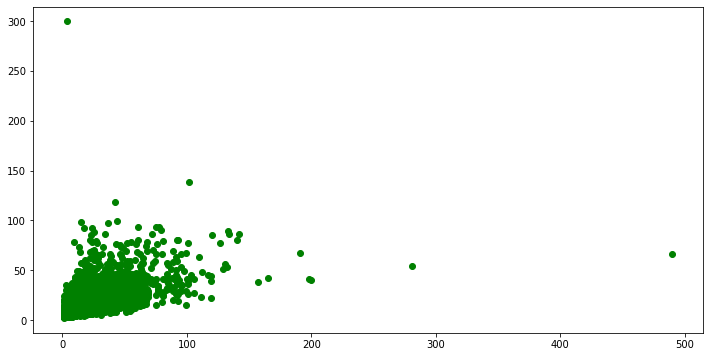

In [ ]:
training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()
x = training["freq"]

plt.figure(figsize=(12, 6))
plt.plot(x, predictions, color='red', label='regression line')     # regression line
plt.scatter(x, predictions, c='green', label='actual values')   # scatter plot showing actual data

In [94]:
#for some reason grouping will not keep duration, time and freq together
#so manually adding it to the subset
freq = specified_dictionary_all.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times", "actobjenc"]).sum().reset_index()["freq"].tolist()

best_train=specified_dictionary_all.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "times", "actobjenc"])[["realtime.min", "dur"]].agg(sum).reset_index()
best_train["freq"] = freq


Neural Network Predictions: Training

In [96]:
training = train.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()

In [97]:
nnmod1 = MLPClassifier(hidden_layer_sizes=(100), activation = 'tanh',
                     solver='lbfgs', verbose=1, random_state=1, max_iter = 50, learning_rate = "adaptive")
nnmod1.fit(best_train[["actenc", "objenc", "actobjenc", "realtime.min", "dur"]],best_train[["freq"]])
y_pred_train = nnmod1.predict(train[["actenc", "objenc", "actobjenc", "realtime.min", "dur"]])

print(accuracy_score(train[["freq"]],y_pred_train))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.9159931786164455


Neural Network Predictions: Test

In [98]:
testing = test.groupby(["hh", "vo.num", "clip", "actenc", "objenc", "actobjenc"])[["realtime.min", "dur", "freq"]].agg(sum).reset_index()

In [99]:
y_pred_test = nnmod1.predict(testing[["actenc", "objenc", "actobjenc", "realtime.min", "dur"]])

print(accuracy_score(testing[["freq"]],y_pred_test))

0.3242873877391644


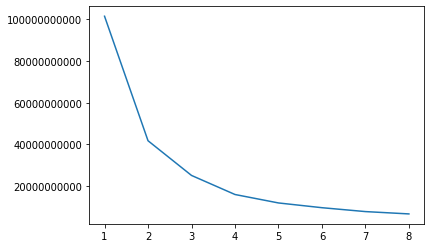

In [ ]:
# #suggests there are 3 main clusters
# df_clust = best_train.loc[:, "realtime.hrs":]
# yax = []
# for i in range(1,9):
#   kmeans = KMeans(n_clusters=i, random_state=42)
#   kmeans.fit(best_train.loc[:, "realtime.hrs":])
#   yax.append(kmeans.inertia_)
# fig, ax = plt.subplots()
# ax.ticklabel_format(style='plain')
# ax.plot(range(1, 9), yax)
# plt.show()

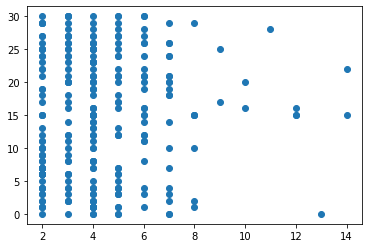

In [ ]:
# plt.scatter(df_clust[df_clust["cluster"]== 2]["freq"], df_clust[df_clust["cluster"]== 2]["realtime.min"])

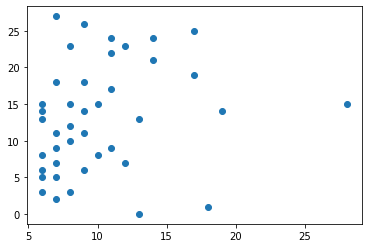

In [ ]:
# plt.scatter(df_clust[df_clust["cluster"]== 1]["freq"], df_clust[df_clust["cluster"]== 1]["realtime.min"])